In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

C:\Users\KIIT\AppData\Local\Temp\ipykernel_1852\2261059165.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
data = pd.read_csv("btc_6h.csv")
data.head()

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564


In [3]:
data.shape

(5959, 6)

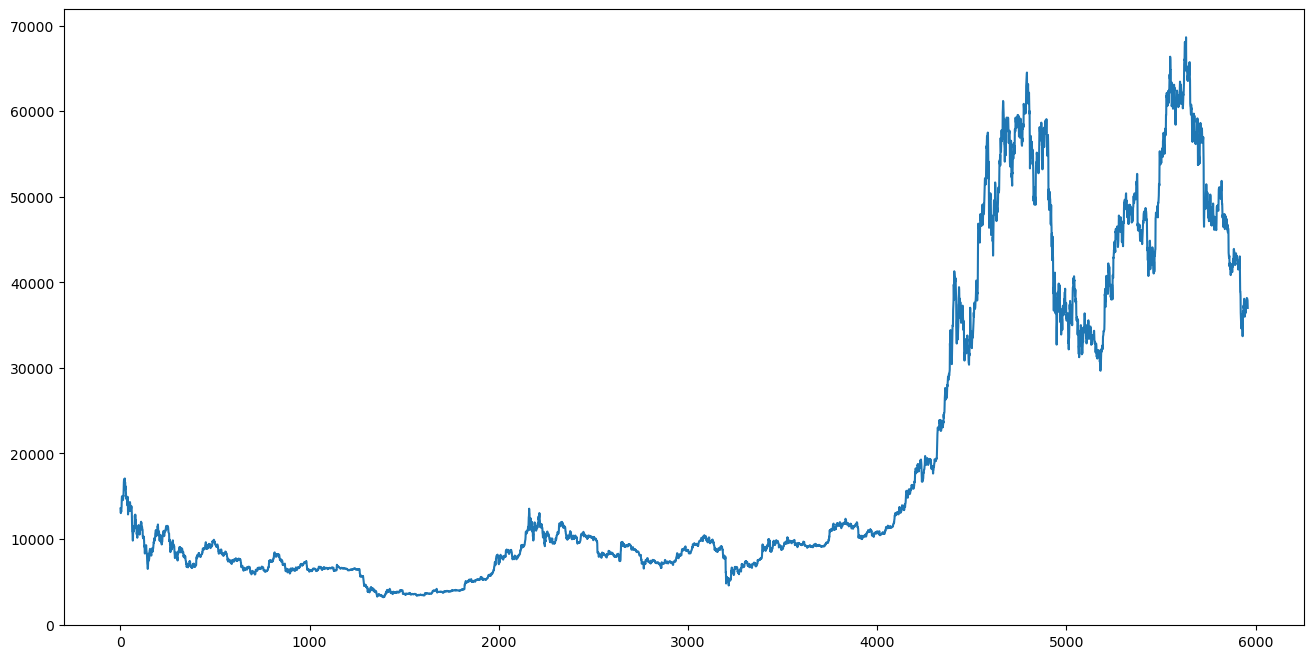

In [4]:
plt.figure(figsize=(16,8))
plt.plot(data['close'])
plt.show()

In [5]:
close_data = data['close']
close_data
close_df = pd.DataFrame(close_data,columns =['close'])
close_df.head()

,close
0,13558.99
1,13220.56
2,13022.00
3,13380.00
4,13166.95


In [6]:
data['next'] = data['close'].shift(-1)

In [7]:
data.head()

,datetime,open,high,low,close,volume,next
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182,13220.56
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392,13022.00
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747,13380.00
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523,13166.95
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564,13490.00


In [8]:
data.dtypes

datetime     object
open        float64
high        float64
low         float64
close       float64
volume      float64
next        float64
dtype: object

Checking Autocorrelation for Time Series Analysis

In [9]:
# Split into train and test sets
X = data['next'].values
size = int(len(X) * 0.8)

# Split first 80% for training
X_train_3 = X[:size]

# Split next 10% (80-90%) for validation
validation_size = int(size + 0.1 * len(X))
X_val_3 = X[size:validation_size]

# Split last 10% (90-100%) for testing
X_test_3 = X[validation_size:]

# Initialize a list to store prediction history
history = [x for x in X_train_3]

In [10]:
# Walk-forward validation using ARIMA model for validation data

val_pred = list()
for t in range(len(X_val_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    val_pred.append(yhat)

    # Update the history with the observed value
    obs = X_val_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=56449.352712, Expected=57749.090000
Predicted=57790.745149, Expected=58077.520000
Predicted=58039.688244, Expected=57947.670000
Predicted=57975.702948, Expected=58527.190000
Predicted=58477.811412, Expected=58405.080000
Predicted=58369.520184, Expected=58142.540000
Predicted=58147.735753, Expected=60851.920000
Predicted=60865.864874, Expected=60575.940000
Predicted=60582.521683, Expected=60100.480000
Predicted=60154.732337, Expected=59769.130000
Predicted=59615.336320, Expected=59679.970000
Predicted=59649.409020, Expected=59721.840000
Predicted=59745.818621, Expected=59864.390000
Predicted=59889.257077, Expected=60002.430000
Predicted=60014.944585, Expected=60207.010000
Predicted=60212.119147, Expected=60241.500000
Predicted=60236.902664, Expected=59749.400000
Predicted=59735.284895, Expected=59860.000000
Predicted=59847.693290, Expected=60668.740000
Predicted=60670.487553, Expected=62942.210000
Predicted=63017.221342, Expected=63332.850000
Predicted=63361.224265, Expected=6

Predicted=36730.237430, Expected=35389.100000
Predicted=35357.670927, Expected=32715.820000
Predicted=32708.383851, Expected=34655.250000
Predicted=34654.446375, Expected=35292.600000
Predicted=35445.529669, Expected=37600.010000
Predicted=37914.266635, Expected=37669.770000
Predicted=37598.091997, Expected=38796.290000
Predicted=38703.897313, Expected=38356.500000
Predicted=38155.849365, Expected=36537.160000
Predicted=36455.245205, Expected=37951.980000
Predicted=37804.290772, Expected=38324.720000
Predicted=38359.600866, Expected=39229.280000
Predicted=39425.291961, Expected=39850.650000
Predicted=39779.604796, Expected=38965.660000
Predicted=38913.682057, Expected=39241.910000
Predicted=39131.158421, Expected=38136.540000
Predicted=38058.590963, Expected=39690.010000
Predicted=39738.256771, Expected=39028.990000
Predicted=39056.250379, Expected=38529.980000
Predicted=38619.054665, Expected=36996.450000
Predicted=36861.962180, Expected=35351.650000
Predicted=35345.840226, Expected=3

Predicted=34131.138191, Expected=34809.730000
Predicted=34867.275627, Expected=34827.960000
Predicted=34858.505198, Expected=34635.010000
Predicted=34605.738339, Expected=33862.120000
Predicted=33806.712984, Expected=32884.560000
Predicted=32861.115765, Expected=32696.440000
Predicted=32696.696103, Expected=32863.830000
Predicted=32941.302693, Expected=32875.710000
Predicted=32975.267324, Expected=32996.180000
Predicted=33019.597649, Expected=32774.990000
Predicted=32766.693962, Expected=33481.070000
Predicted=33467.191916, Expected=33815.810000
Predicted=33828.299805, Expected=33649.030000
Predicted=33666.198445, Expected=33793.940000
Predicted=33725.046834, Expected=33397.270000
Predicted=33369.814205, Expected=33502.870000
Predicted=33499.575673, Expected=33590.530000
Predicted=33588.665159, Expected=33814.840000
Predicted=33847.525294, Expected=33892.810000
Predicted=33892.575196, Expected=34258.990000
Predicted=34247.801416, Expected=34330.250000
Predicted=34319.400711, Expected=3

Predicted=48563.500368, Expected=49322.470000
Predicted=49331.422810, Expected=48836.760000
Predicted=48822.378626, Expected=48501.870000
Predicted=48354.011346, Expected=49647.880000
Predicted=49590.180470, Expected=48821.870000
Predicted=48888.983281, Expected=49129.760000
Predicted=49107.107067, Expected=49132.040000
Predicted=49083.655937, Expected=48677.280000
Predicted=48720.765964, Expected=49239.220000
Predicted=49209.977645, Expected=50220.940000
Predicted=50235.399738, Expected=50394.850000
Predicted=50432.297336, Expected=49413.670000
Predicted=49363.335361, Expected=49488.850000
Predicted=49391.269910, Expected=49557.770000
Predicted=49564.060071, Expected=49429.990000
Predicted=49496.430961, Expected=48001.010000
Predicted=48009.046643, Expected=47674.010000
Predicted=47644.670474, Expected=48520.020000
Predicted=48553.164392, Expected=47570.010000
Predicted=47698.716268, Expected=48830.000000
Predicted=48813.976673, Expected=48973.320000
Predicted=48965.904994, Expected=4

In [11]:
# Convert validation and predictions to DataFrames for plotting
val_df = DataFrame(X_val_3, index=data['next'].index[size:validation_size], columns=['Actual'])
val_pred_df = DataFrame(val_pred, index=data['next'].index[size:validation_size], columns=['Predicted'])

# Evaluate forecasts for validation data
mse_val = mean_squared_error(val_df, val_pred_df)
rmse_val = np.sqrt(mse_val)

# Calculate R-squared (R^2) score for validation data
r2_val = r2_score(val_df, val_pred_df)

# Calculate Mean Absolute Error (MAE) for validation data
mae_val = mean_absolute_error(val_df, val_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for validation data
mape_val = np.mean(np.abs((np.array(val_df) - np.array(val_pred_df)) / np.array(val_df))) * 100

# Print results for validation data
print(f'Mean Squared Error (MSE) for Validation Data: {mse_val:.3f}')
print(f'Root Mean Squared Error (RMSE) for Validation Data: {rmse_val:.3f}')
print(f'R-squared (R^2) Score for Validation Data: {r2_val:.3f}')
print(f'Mean Absolute Error (MAE) for Validation Data: {mae_val:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Validation Data: {mape_val:.3f}%')

Mean Squared Error (MSE) for Validation Data: 932577.839
Root Mean Squared Error (RMSE) for Validation Data: 965.701
R-squared (R^2) Score for Validation Data: 0.989
Mean Absolute Error (MAE) for Validation Data: 693.863
Mean Absolute Percentage Error (MAPE) for Validation Data: 1.642%


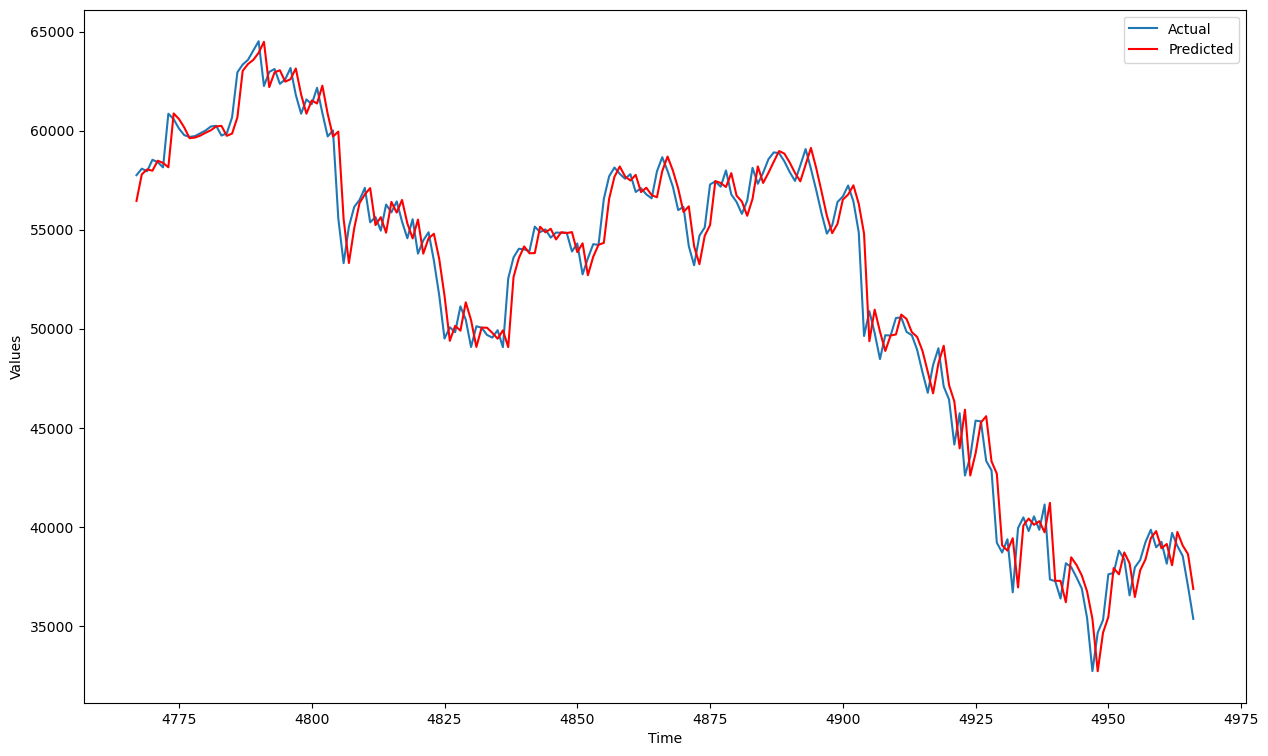

In [12]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values = val_df['Actual'].iloc[start_index:end_index]
predicted_values = val_pred_df['Predicted'].iloc[start_index:end_index]
time_index = val_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index, actual_values, label='Actual')

# Plot predicted values in red
plt.plot(time_index, predicted_values, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [13]:
test_pred = list()
for t in range(len(X_test_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    test_pred.append(yhat)

    # Update the history with the observed value
    obs = X_test_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=50218.486700, Expected=49902.940000
Predicted=50218.486700, Expected=49954.830000
Predicted=50218.486700, Expected=49915.640000
Predicted=50218.486700, Expected=49688.800000
Predicted=50218.486700, Expected=50198.780000
Predicted=50218.486700, Expected=50299.690000
Predicted=50218.486700, Expected=51756.880000
Predicted=50218.486700, Expected=51759.990000
Predicted=50218.486700, Expected=51400.670000
Predicted=50218.486700, Expected=51672.980000
Predicted=50218.486700, Expected=52663.900000
Predicted=50218.486700, Expected=52665.010000
Predicted=50218.486700, Expected=50941.480000
Predicted=50218.486700, Expected=46606.440000
Predicted=50218.486700, Expected=46863.730000
Predicted=50218.486700, Expected=46074.840000
Predicted=50218.486700, Expected=46394.090000
Predicted=50218.486700, Expected=46200.190000
Predicted=50218.486700, Expected=46048.310000
Predicted=50218.486700, Expected=46304.440000
Predicted=50218.486700, Expected=46293.150000
Predicted=50218.486700, Expected=4

Predicted=50218.486700, Expected=62476.650000
Predicted=50218.486700, Expected=62128.390000
Predicted=50218.486700, Expected=63411.270000
Predicted=50218.486700, Expected=64280.590000
Predicted=50218.486700, Expected=63779.410000
Predicted=50218.486700, Expected=63791.100000
Predicted=50218.486700, Expected=66363.020000
Predicted=50218.486700, Expected=66001.410000
Predicted=50218.486700, Expected=64825.710000
Predicted=50218.486700, Expected=64827.900000
Predicted=50218.486700, Expected=62487.000000
Predicted=50218.486700, Expected=62193.150000
Predicted=50218.486700, Expected=63013.040000
Predicted=50218.486700, Expected=63376.800000
Predicted=50218.486700, Expected=60576.030000
Predicted=50218.486700, Expected=60688.220000
Predicted=50218.486700, Expected=60990.000000
Predicted=50218.486700, Expected=61552.230000
Predicted=50218.486700, Expected=61239.010000
Predicted=50218.486700, Expected=61286.750000
Predicted=50218.486700, Expected=60900.000000
Predicted=50218.486700, Expected=6

Predicted=50218.486700, Expected=56480.340000
Predicted=50218.486700, Expected=56725.860000
Predicted=50218.486700, Expected=56959.770000
Predicted=50218.486700, Expected=54982.310000
Predicted=50218.486700, Expected=53601.050000
Predicted=50218.486700, Expected=47538.030000
Predicted=50218.486700, Expected=46489.670000
Predicted=50218.486700, Expected=48241.050000
Predicted=50218.486700, Expected=49152.470000
Predicted=50218.486700, Expected=49424.000000
Predicted=50218.486700, Expected=49242.580000
Predicted=50218.486700, Expected=49262.210000
Predicted=50218.486700, Expected=49396.330000
Predicted=50218.486700, Expected=48678.540000
Predicted=50218.486700, Expected=48577.780000
Predicted=50218.486700, Expected=48961.230000
Predicted=50218.486700, Expected=50441.920000
Predicted=50218.486700, Expected=50872.920000
Predicted=50218.486700, Expected=51456.200000
Predicted=50218.486700, Expected=50999.970000
Predicted=50218.486700, Expected=50588.950000
Predicted=50218.486700, Expected=5

Predicted=50218.486700, Expected=43071.880000
Predicted=50218.486700, Expected=43071.660000
Predicted=50218.486700, Expected=42664.680000
Predicted=50218.486700, Expected=42671.310000
Predicted=50218.486700, Expected=42110.830000
Predicted=50218.486700, Expected=42201.620000
Predicted=50218.486700, Expected=42097.250000
Predicted=50218.486700, Expected=41854.140000
Predicted=50218.486700, Expected=41489.040000
Predicted=50218.486700, Expected=42352.120000
Predicted=50218.486700, Expected=41762.550000
Predicted=50218.486700, Expected=42033.000000
Predicted=50218.486700, Expected=42151.010000
Predicted=50218.486700, Expected=41660.010000
Predicted=50218.486700, Expected=41879.200000
Predicted=50218.486700, Expected=42129.440000
Predicted=50218.486700, Expected=43025.850000
Predicted=50218.486700, Expected=40680.910000
Predicted=50218.486700, Expected=38909.010000
Predicted=50218.486700, Expected=38898.180000
Predicted=50218.486700, Expected=38382.500000
Predicted=50218.486700, Expected=3

In [14]:
# Convert test and predictions to DataFrames for plotting
test_df = DataFrame(X_test_3, index=data['next'].index[validation_size:], columns=['Actual'])
test_pred_df = DataFrame(test_pred, index=data['next'].index[validation_size:], columns=['Predicted'])

In [15]:
test_df.drop(test_df.tail(1).index, inplace=True)

In [16]:
test_pred_df.drop(test_pred_df.tail(1).index, inplace=True)

In [17]:
# Evaluate forecasts for test data
mse_test = mean_squared_error(test_df, test_pred_df)
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) score for test data
r2_test = r2_score(test_df, test_pred_df)

# Calculate Mean Absolute Error (MAE) for test data
mae_test = mean_absolute_error(test_df, test_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for test data
mape_test = np.mean(np.abs((np.array(test_df) - np.array(test_pred_df)) / np.array(test_df))) * 100

# Print results for test data
print(f'Mean Squared Error (MSE) for Test Data: {mse_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 67839419.232
Root Mean Squared Error (RMSE) for Test Data: 8236.469
R-squared (R^2) Score for Test Data: -0.010
Mean Absolute Error (MAE) for Test Data: 6947.281
Mean Absolute Percentage Error (MAPE) for Test Data: 13.753%


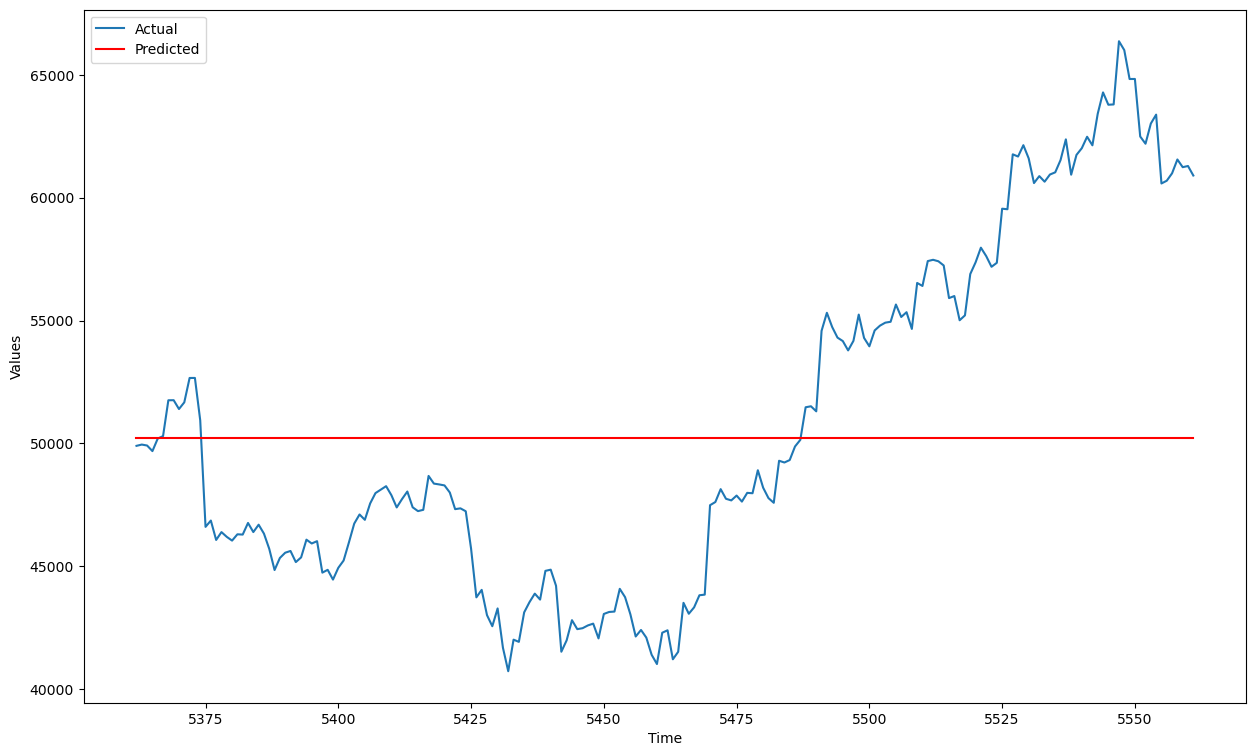

In [18]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values_test = test_df['Actual'].iloc[start_index:end_index]
predicted_values_test = test_pred_df['Predicted'].iloc[start_index:end_index]
time_index_test = test_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index_test, actual_values_test, label='Actual')

# Plot predicted values in red
plt.plot(time_index_test, predicted_values_test, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

## Out sample Testing

In [79]:


out_sample_test_2023 = pd.read_csv('BTC-USD.csv')

In [ ]:
outsample_test_data = list(out_sample_test_2023['Close'].values)
history_all = list(data['close'].values)

In [39]:
outsample_test_data

[38743.273438,
 36952.984375,
 37154.601563,
 41500.875,
 41441.164063,
 42412.433594,
 43840.285156,
 44118.445313,
 44338.796875,
 43565.113281,
 42407.9375,
 42244.46875,
 42197.515625,
 42586.917969,
 44575.203125,
 43961.859375,
 40538.011719,
 40030.976563,
 40122.15625,
 38431.378906,
 37075.28125,
 38286.027344,
 37296.570313,
 38332.609375,
 39214.21875,
 39105.148438,
 37709.785156,
 43193.234375,
 44354.636719,
 43924.117188,
 42451.789063,
 39137.605469,
 39400.585938,
 38419.984375,
 38062.039063,
 38737.269531,
 41982.925781,
 39437.460938,
 38794.972656,
 38904.011719,
 37849.664063,
 39666.753906,
 39338.785156,
 41143.929688,
 40951.378906,
 41801.15625,
 42190.652344,
 41247.824219,
 41077.996094,
 42358.808594,
 42892.957031,
 43960.933594,
 44348.730469,
 44500.828125,
 46820.492188,
 47128.003906,
 47465.730469,
 47062.664063,
 45538.675781,
 46281.644531,
 45868.949219,
 46453.566406,
 46622.675781,
 45555.992188,
 43206.738281,
 43503.847656,
 42287.664063,
 4278

In [59]:
predictions = []
for t in range(len(outsample_test_data)):
    Model = ARIMA(history_all, order = (5,1,0))
    Model_fit = Model.fit()
    output = Model_fit.forecast(steps = 30)
    y_hat = output[0]
    predictions.append(y_hat)
    observation = outsample_test_data[t]
    history_all.append(observation)
    
    print('Predicted=%f, Expected=%f' % (y_hat, observation))
    

Predicted=43655.262833, Expected=38743.273438
Predicted=38998.285871, Expected=36952.984375
Predicted=36963.767089, Expected=37154.601563
Predicted=36976.396982, Expected=41500.875000
Predicted=41617.265562, Expected=41441.164063
Predicted=41610.208282, Expected=42412.433594
Predicted=42533.121157, Expected=43840.285156
Predicted=43589.446020, Expected=44118.445313
Predicted=44047.699590, Expected=44338.796875
Predicted=44328.201683, Expected=43565.113281
Predicted=43498.832842, Expected=42407.937500
Predicted=42396.344793, Expected=42244.468750
Predicted=42213.339383, Expected=42197.515625
Predicted=42200.119747, Expected=42586.917969
Predicted=42647.647488, Expected=44575.203125
Predicted=44566.288548, Expected=43961.859375
Predicted=43984.139506, Expected=40538.011719
Predicted=40643.298942, Expected=40030.976563
Predicted=39935.257465, Expected=40122.156250
Predicted=40021.224746, Expected=38431.378906
Predicted=38630.761608, Expected=37075.281250
Predicted=37208.698844, Expected=3

Predicted=23888.662561, Expected=23656.207031
Predicted=23608.628302, Expected=23336.896484
Predicted=23262.291781, Expected=23314.199219
Predicted=23292.937044, Expected=22978.117188
Predicted=22983.427157, Expected=22846.507813
Predicted=22867.609915, Expected=22630.957031
Predicted=22633.360567, Expected=23289.314453
Predicted=23288.557398, Expected=22961.279297
Predicted=22974.228537, Expected=23175.890625
Predicted=23205.065775, Expected=23809.486328
Predicted=23758.898302, Expected=23164.318359
Predicted=23185.100192, Expected=23947.642578
Predicted=23948.013154, Expected=23957.529297
Predicted=23901.308435, Expected=24402.818359
Predicted=24434.823894, Expected=24424.068359
Predicted=24399.427317, Expected=24319.333984
Predicted=24317.855682, Expected=24136.972656
Predicted=24119.917253, Expected=23883.291016
Predicted=23875.104566, Expected=23335.998047
Predicted=23346.881142, Expected=23212.738281
Predicted=23219.310391, Expected=20877.552734
Predicted=20925.955476, Expected=2

Predicted=22601.810044, Expected=23117.859375
Predicted=23115.574465, Expected=23032.777344
Predicted=23015.729157, Expected=23078.728516
Predicted=23102.558214, Expected=23031.089844
Predicted=23012.060338, Expected=23774.566406
Predicted=23754.981602, Expected=22840.138672
Predicted=22856.665805, Expected=23139.283203
Predicted=23157.731399, Expected=23723.769531
Predicted=23647.811079, Expected=23471.871094
Predicted=23515.544465, Expected=23449.322266
Predicted=23472.938033, Expected=23331.847656
Predicted=23291.658462, Expected=22955.666016
Predicted=22962.760650, Expected=22760.109375
Predicted=22767.382990, Expected=23264.291016
Predicted=23249.017682, Expected=22939.398438
Predicted=22960.559214, Expected=21819.039063
Predicted=21875.191203, Expected=21651.183594
Predicted=21625.541868, Expected=21870.875000
Predicted=21837.799308, Expected=21788.203125
Predicted=21846.170433, Expected=21808.101563
Predicted=21846.449553, Expected=22220.804688
Predicted=22202.703939, Expected=2

Predicted=29774.575888, Expected=30084.539063
Predicted=30085.836367, Expected=29176.916016
Predicted=29189.587267, Expected=29227.390625
Predicted=29238.125614, Expected=29354.972656
Predicted=29312.775694, Expected=29210.689453
Predicted=29252.180550, Expected=29319.246094
Predicted=29337.348421, Expected=29356.917969
Predicted=29344.784698, Expected=29275.308594
Predicted=29284.592981, Expected=29230.111328
Predicted=29229.935339, Expected=29675.732422
Predicted=29659.626873, Expected=29151.958984
Predicted=29165.652376, Expected=29178.679688
Predicted=29194.564693, Expected=29074.091797
Predicted=29040.141613, Expected=29042.126953
Predicted=29058.948515, Expected=29041.855469
Predicted=29048.449830, Expected=29180.578125
Predicted=29181.077069, Expected=29765.492188
Predicted=29757.075169, Expected=29561.494141
Predicted=29571.856447, Expected=29429.591797
Predicted=29443.182437, Expected=29397.714844
Predicted=29361.099731, Expected=29415.964844
Predicted=29408.832564, Expected=2

In [75]:
#converting vlaues to dataframe
predictions_df = pd.DataFrame( predictions,columns = ['predictions'])
outsample_df = pd.DataFrame(outsample_test_data, columns = ['close'])
print(outsample_df.shape , predictions_df.shape)

(704, 1) (704, 1)


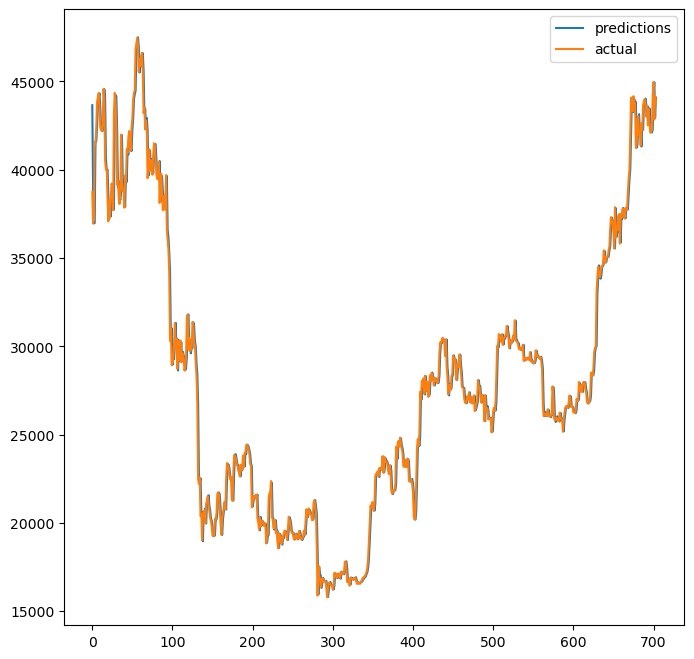

In [78]:

plt.figure(figsize = (8,8))
plt.plot(predictions_df['predictions'], label = "predictions")
plt.plot(outsample_df['close'], label = "actual")
plt.legend()
plt.show()


In [77]:
mse_outsample_test = mean_squared_error(predictions_df,outsample_df)
rmse_outsample_test = sqrt(mse_outsample_test)
r2_outsample_test = r2_score(predictions_df, outsample_df)
mae_outsample_test = mean_absolute_error(predictions_df, outsample_df)
mape_outsample_test = np.mean(np.abs((np.array(predictions_df) - np.array(outsample_df)) / np.array(outsample_df))) * 100

print(f'Mean Squared Error (MSE) for Test Data: {mse_outsample_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_outsample_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_outsample_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_outsample_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_outsample_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 749718.195
Root Mean Squared Error (RMSE) for Test Data: 865.863
R-squared (R^2) Score for Test Data: 0.989
Mean Absolute Error (MAE) for Test Data: 546.314
Mean Absolute Percentage Error (MAPE) for Test Data: 1.915%


In [80]:
out_sample_returns = out_sample_test_2023['Close'].pct_change()
returns = pd.DataFrame(out_sample_returns,columns = ['actual'])
out_sample_returns

0           NaN
1     -0.046209
2      0.005456
3      0.116978
4     -0.001439
         ...   
699    0.045005
700    0.017901
701   -0.046928
702    0.031081
703   -0.009000
Name: Close, Length: 704, dtype: float64